1.Analyze the time series characteristics
2.Test for causation amongst the time series
3.Test for stationarity
4.Transform the series to make it stationary, if needed
5.Find optimal order (p)
6.Prepare training and test datasets
7.Train the model
8.Roll back the transformations, if any.
9.Evaluate the model using test set
10.Forecast to future

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import statsmodel
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [7]:
ab=pd.read_csv('analogdata5.csv')

In [8]:
ab.head()

,CO2(PPM),AQI(PPM),CO(PPM),LPG(PPM),BUTANE(PPM),SMOKE(PPM),TEMP,DAYS
0,688,88.59,256,0.01,0.0,0.02,36,MON
1,679,78.76,253,0.01,0.0,0.02,36,MON
2,671,71.04,250,0.01,0.0,0.02,36,MON
3,663,64.15,249,0.01,0.0,0.02,36,MON
4,654,57.26,246,0.01,0.0,0.02,36,MON


In [10]:
df=ab.set_index('DAYS')

In [11]:
df.head()

,CO2(PPM),AQI(PPM),CO(PPM),LPG(PPM),BUTANE(PPM),SMOKE(PPM),TEMP
DAYS,,,,,,,
MON,688,88.59,256,0.01,0.0,0.02,36
MON,679,78.76,253,0.01,0.0,0.02,36
MON,671,71.04,250,0.01,0.0,0.02,36
MON,663,64.15,249,0.01,0.0,0.02,36
MON,654,57.26,246,0.01,0.0,0.02,36


In [14]:
df.drop('BUTANE(PPM)',axis=1,inplace=True)

In [15]:
df.head()

,CO2(PPM),AQI(PPM),CO(PPM),LPG(PPM),SMOKE(PPM),TEMP
DAYS,,,,,,
MON,688,88.59,256,0.01,0.02,36
MON,679,78.76,253,0.01,0.02,36
MON,671,71.04,250,0.01,0.02,36
MON,663,64.15,249,0.01,0.02,36
MON,654,57.26,246,0.01,0.02,36


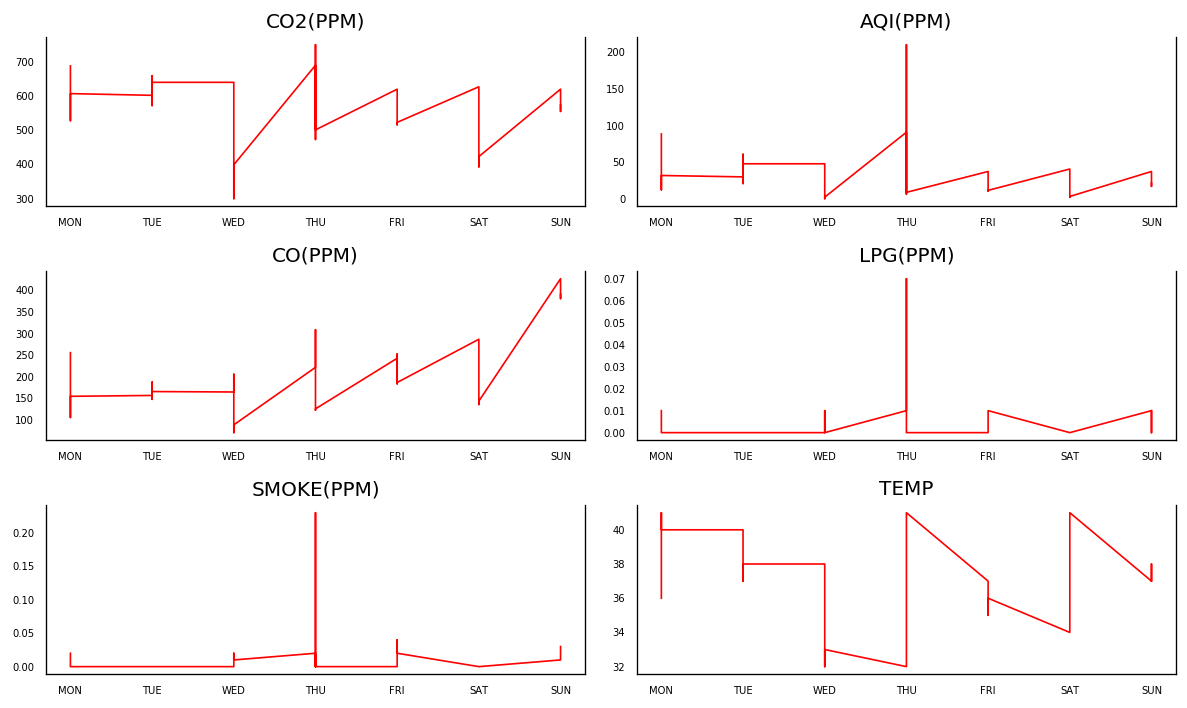

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout()

In [20]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,CO2(PPM)_x,AQI(PPM)_x,CO(PPM)_x,LPG(PPM)_x,SMOKE(PPM)_x,TEMP_x
CO2(PPM)_y,1.0000,0.0006,0.0008,0.1004,0.000,0.2782
AQI(PPM)_y,0.0000,1.0000,0.0000,0.0000,0.000,0.1572
CO(PPM)_y,0.3565,0.0650,1.0000,0.1862,0.000,0.1291
LPG(PPM)_y,0.0329,0.0000,0.0000,1.0000,0.000,0.0716
SMOKE(PPM)_y,0.0640,0.0000,0.0001,0.0000,1.000,0.0016
TEMP_y,0.0757,0.1744,0.0000,0.1198,0.091,1.0000


In [21]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
CO2(PPM) ::  240.31    > 83.9383   =>   True
AQI(PPM) ::  112.54    > 60.0627   =>   True
CO(PPM) ::  35.69     > 40.1749   =>   False
LPG(PPM) ::  11.84     > 24.2761   =>   False
SMOKE(PPM) ::  2.1       > 12.3212   =>   False
TEMP   ::  0.19      > 4.1296    =>   False


In [22]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(3965, 6)
(4, 6)


In [23]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [24]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CO2(PPM)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1337
 No. Lags Chosen       = 1
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0242. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AQI(PPM)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.871
 No. Lags Chosen       = 9
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO(PPM)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Lev

In [26]:

df_differenced = df_train.diff().dropna()

In [27]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CO2(PPM)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -65.4296
 No. Lags Chosen       = 0
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AQI(PPM)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.5782
 No. Lags Chosen       = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO(PPM)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [28]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -21.402061748712747
BIC :  -21.335455698519965
FPE :  5.072273825075102e-10
HQIC:  -21.37844048936797 

Lag Order = 2
AIC :  -21.454854199557765
BIC :  -21.331130996699066
FPE :  4.811442194364314e-10
HQIC:  -21.410976273699873 

Lag Order = 3
AIC :  -21.571105881647778
BIC :  -21.39024127550567
FPE :  4.283393159499595e-10
HQIC:  -21.506962169143346 

Lag Order = 4
AIC :  -21.61530070385217
BIC :  -21.37727042717609
FPE :  4.098213850492688e-10
HQIC:  -21.53088207812899 

Lag Order = 5
AIC :  -21.620862099670763
BIC :  -21.32564186856146
FPE :  4.075489045780381e-10
HQIC:  -21.51615942771169 

Lag Order = 6
AIC :  -21.62731418636167
BIC :  -21.274879700255536
FPE :  4.049283741053837e-10
HQIC:  -21.50231832869843 

Lag Order = 7
AIC :  -21.668921940276835
BIC :  -21.25924888193025
FPE :  3.8842663449172654e-10
HQIC:  -21.523623750983855 

Lag Order = 8
AIC :  -21.678554160933125
BIC :  -21.211618196406754
FPE :  3.8470413442710183e-10
HQIC:  -21.512944487621343 



In [29]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Apr, 2021
Time:                     11:30:53
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -21.3902
Nobs:                     3961.00    HQIC:                  -21.5070
Log likelihood:           9113.08    FPE:                4.28339e-10
AIC:                     -21.5711    Det(Omega_mle):     4.16216e-10
--------------------------------------------------------------------
Results for equation CO2(PPM)
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.034327         0.141955           -0.242           0.809
L1.CO2(PPM)           0.041153         0.036916            1.115           0.265
L1.AQI(PPM)          -0.496988         0.108391          

In [42]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

CO2(PPM) : 2.0
AQI(PPM) : 2.0
CO(PPM) : 2.0
LPG(PPM) : 2.02
SMOKE(PPM) : 2.02
TEMP : 1.99


In [43]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.27, 0.  , 0.  , 0.  , 0.  ]])

In [44]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,CO2(PPM)_2d,AQI(PPM)_2d,CO(PPM)_2d,LPG(PPM)_2d,SMOKE(PPM)_2d,TEMP_2d
DAYS,,,,,,
SUN,-0.127361,-0.066540,0.048250,-9.257954e-06,-0.000023,0.002771
SUN,-0.040870,-0.024707,0.062222,3.081718e-06,-0.000002,0.000274
SUN,-0.009360,-0.018255,0.038493,3.736746e-07,-0.000002,0.000385
SUN,-0.019567,-0.004447,0.034995,1.281626e-06,0.000012,-0.000096


In [36]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [39]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['CO2(PPM)_forecast', 'AQI(PPM)_pgnp_forecast', 'CO(PPM)_forecast', 'LPG(PPM)_forecast',
                   'SMOKE(PPM)_forecast', 'TEMP_forecast']]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

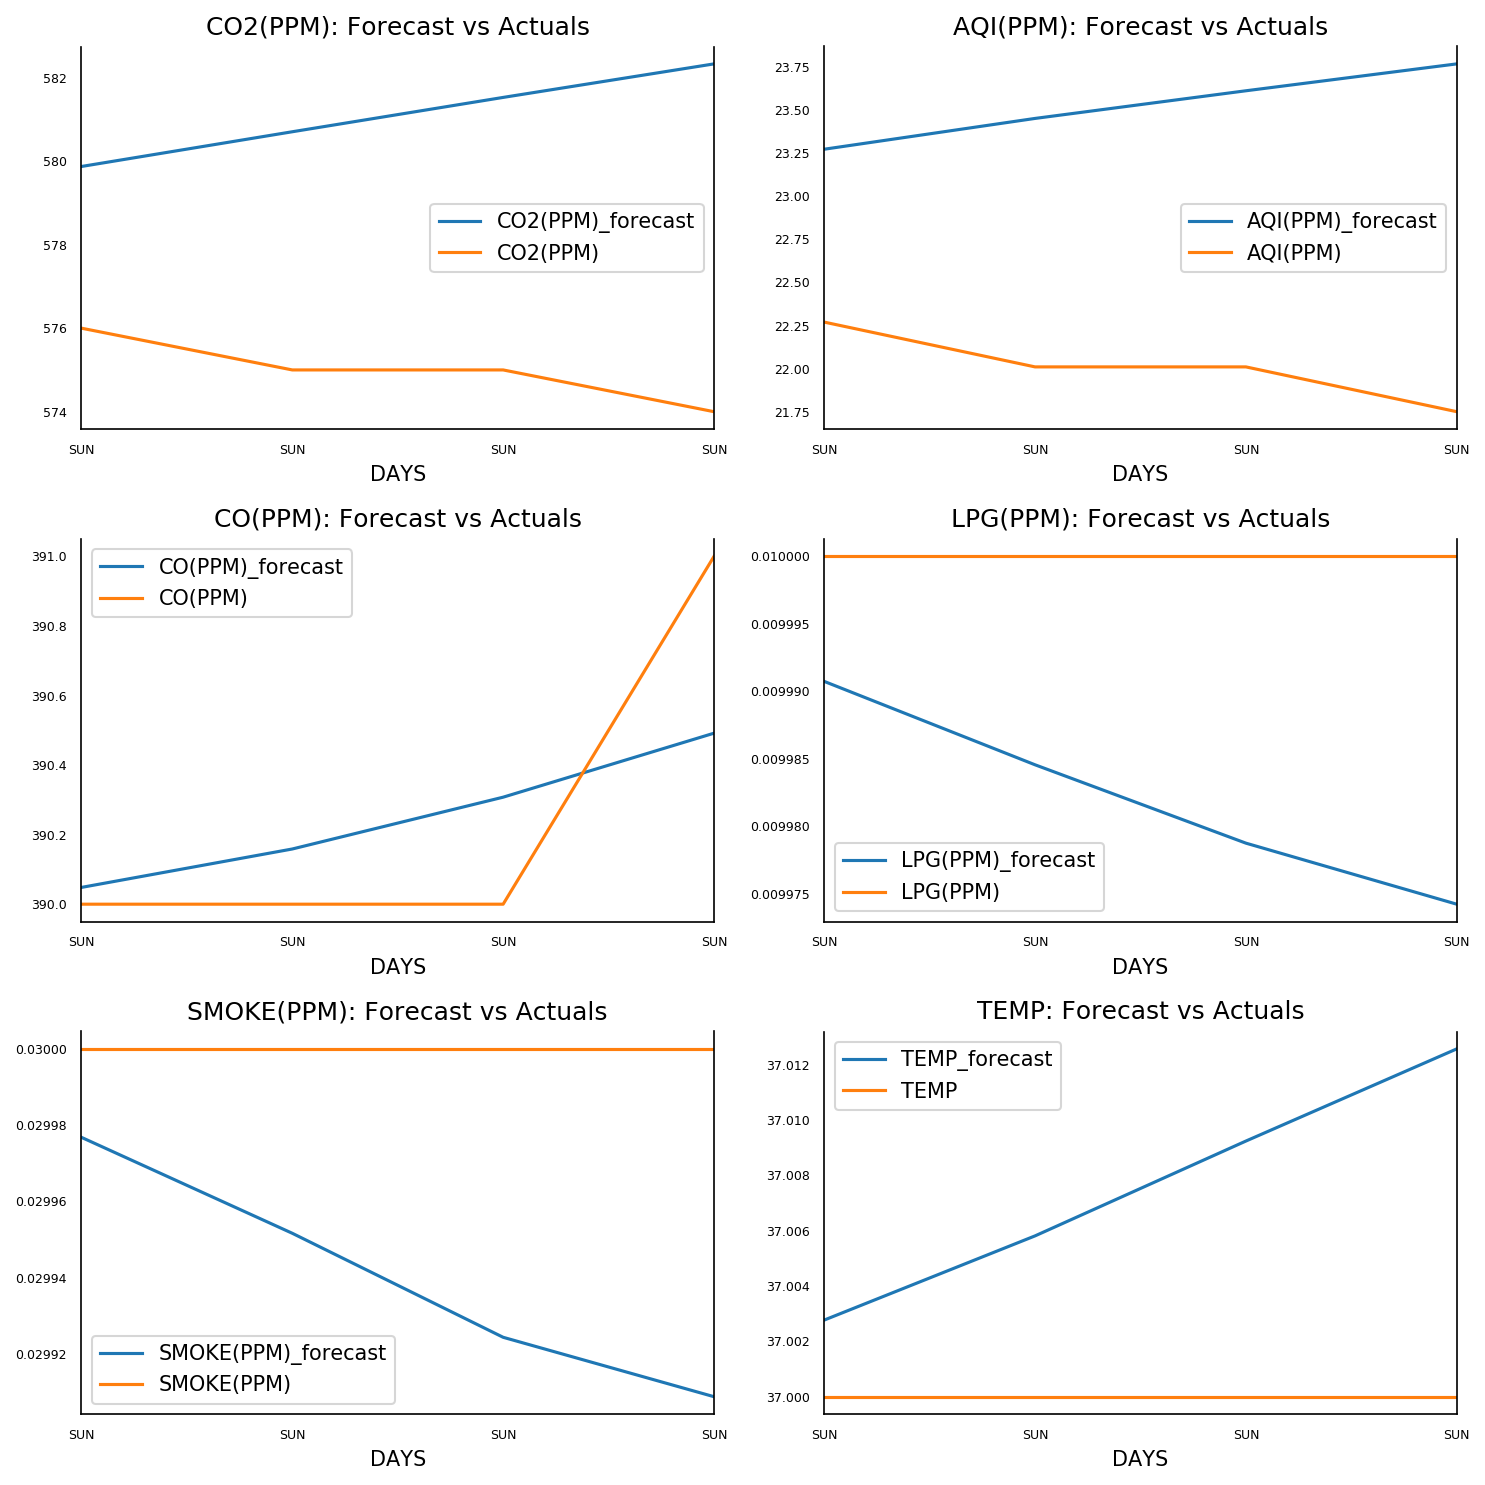

In [45]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [50]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({ 'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe,'rmse':rmse, 'corr':corr})

print('Forecast Accuracy of: CO2(PPM)')
accuracy_prod = forecast_accuracy(df_results['CO2(PPM)_forecast'].values, df_test['CO2(PPM)'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: AQI(PPM)')
accuracy_prod = forecast_accuracy(df_results['AQI(PPM)_forecast'].values, df_test['AQI(PPM)'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: CO(PPM)')
accuracy_prod = forecast_accuracy(df_results['CO(PPM)_forecast'].values, df_test['CO(PPM)'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: LPG(PPM)')
accuracy_prod = forecast_accuracy(df_results['LPG(PPM)_forecast'].values, df_test['LPG(PPM)'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: SMOKE(PPM)')
accuracy_prod = forecast_accuracy(df_results['SMOKE(PPM)_forecast'].values, df_test['SMOKE(PPM)'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: TEMP')
accuracy_prod = forecast_accuracy(df_results['TEMP_forecast'].values, df_test['TEMP'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: CO2(PPM)
mape :  0.0106
me :  6.1084
mae :  6.1084
mpe :  0.0106
rmse :  6.3151
corr :  -0.9483

Forecast Accuracy of: AQI(PPM)
mape :  0.0691
me :  1.5168
mae :  1.5168
mpe :  0.0691
rmse :  1.5597
corr :  -0.9509

Forecast Accuracy of: CO(PPM)
mape :  0.0007
me :  0.0016
mae :  0.2558
mpe :  0.0
rmse :  0.3085
corr :  0.833

Forecast Accuracy of: LPG(PPM)
mape :  0.0018
me :  -0.0
mae :  0.0
mpe :  -0.0018
rmse :  0.0
corr :  nan

Forecast Accuracy of: SMOKE(PPM)
mape :  0.002
me :  -0.0001
mae :  0.0001
mpe :  -0.002
rmse :  0.0001
corr :  nan

Forecast Accuracy of: TEMP
mape :  0.0002
me :  0.0076
mae :  0.0076
mpe :  0.0002
rmse :  0.0084
corr :  nan


C:\Users\HP\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\HP\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\HP\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\HP\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\HP\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\HP\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
